In [5]:
import json
import requests
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import pandas as pd

In [2]:
def get_details (site, start_date, end_date):
    url = 'https://nwis.waterservices.usgs.gov/nwis/iv/?site={site}&startDT={start}&endDT={end}&parameterCD=00060&format=json'.format(site=site, start=start_date, end=end_date)

    req = requests.get(url)

    if req.status_code != 200 :
        print('request has returned with status {}'.format(req.status_code))
        return

    resp_data = json.loads(req.text)
    # I need the data itself, the bad value, unit, variable description and name
    # discard unneeded data
    resp_data = resp_data['value']['timeSeries'][0]

    # begin building what I'll return
    good_data = {}
    # I will use this to keep track of any problems that I don't want to stop on
    good_data['problems'] = []

    # get site number (I want to be sure they match)
    site_num = resp_data['sourceInfo']['siteCode'][0]['value']
    good_data['site_num'] = site_num
    if site_num != site :
        good_data['problems'].append('Site number in response {} does not match given {}'.format(site_num, site))

    # get site name
    good_data['siteName'] = resp_data['sourceInfo']['siteName']

    # get huc code
    huc_code = next(i for i in resp_data['sourceInfo']['siteProperty'] if i['name'] == 'hucCd')
    good_data['huc_code'] = huc_code['value']

    # get no-data value
    no_value = resp_data['variable']['noDataValue']

    # get variable description
    var_description = resp_data['variable']['variableDescription']
    good_data['var_description'] = var_description

    # get datapoints
    good_data['series'] = []
    good_data['value'] = []
    good_data['datetime'] = []
    for item in resp_data['values'][0]['value'] :
        if item['value'] == no_value:
            item['value'] = None
        del item['qualifiers']
        good_data['series'].append(item)
        good_data['value'].append(item['value'])
        good_data['datetime'].append(item['dateTime'])
    
    df = pd.DataFrame(data = good_data['value'],index = good_data['datetime'])
    df.columns = ['streamflow']

    
    
    return good_data, df

# gives results of get_details, but filtered to unique site numbers using stations that match the given start and end dates
# Obviously incomplete
def get_dated_details(state, start, end):
    data = get_details(state)
    return None

In [6]:
data_downstream, df_downstream = get_details(site =11251000, start_date = '2019-01-01',end_date ='2022-02-08')
data_upstream, df_upstream = get_details(site =11224000, start_date = '2019-01-01',end_date ='2022-02-08')
data_three, df_three = get_details(site =11303500, start_date = '2019-01-01',end_date ='2022-02-08')
data_four, df_four = get_details(site =11274000, start_date = '2019-01-01',end_date ='2022-02-08')
from dateutil import parser
dt_down = [parser.parse(i) for i in df_downstream.index]
dt_up = [parser.parse(i) for i in df_upstream.index]
dt_three = [parser.parse(i) for i in df_three.index]
dt_four = [parser.parse(i) for i in df_four.index]
creek_start = dt.datetime(year = 2020,month = 8,day = 4)
creek_end = dt.datetime(year = 2020,month = 12,day = 24)

In [7]:
site_ids = [11251000, 11224000, 11303500, 11274000]
lat = [36.98439397, 37.63194444, 37.6760406 , 37.3504928]
lon = [-119.7243124, -119.0863889 ,-121.2663293 ,-120.97715]
elev = [296.55, 7580, 25,56]
area = [1676, 42.,13539,9520 ]
river = ['SanJoaquin','SanJoaquin','SanJoaquin','SanJoaquin']
metadata = pd.DataFrame(data = [site_ids,lat,lon,elev,area,river])

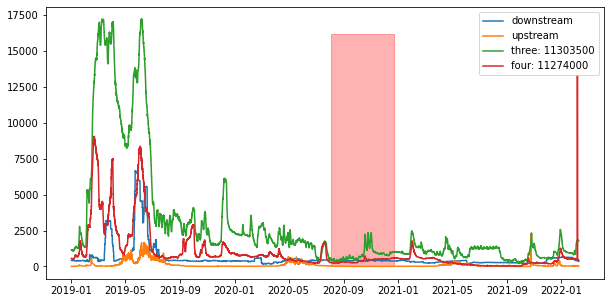

In [8]:
fig,ax = plt.subplots(figsize=(10,5))
ax.plot(dt_down, df_downstream.values.astype('float'),'-',label = 'downstream')
ax.plot(dt_up, df_upstream.values.astype('float'),'-',label = 'upstream')
ax.plot(dt_three, df_three.values.astype('float'),'-',label = 'three: 11303500')
ax.plot(dt_four, df_four.values.astype('float'),'-',label = 'four: 11274000')
y =  df_upstream.values.astype('float').flatten()
ax.fill_betweenx([np.nanmin(y),7 * np.nanmax(y)],creek_start,creek_end,color='red',alpha = 0.3)
# ax.set_ylim(-10,1000)
ax.legend()
plt.show()